# SMART Goals: Classification & Feedback Generation

This pipeline was a component of a service to provide advice on setting better S.M.A.R.T. goals. The service is supposed to look at the user's input, decide whether the goal is S.M.A.R.T. and give the user suggestions. As a starting point, I wanted to see how basic classifiers and old, open-source transformers would perform on this task.

The pipeline has the following steps:

1. **Classify the goals into S.M.A.T.** by hyperparameter-tuning a Random Forest Classifier, a Support Vector Classifier, and a Logistic Regression Classifier and then combining them into an ensemble model of a hard and soft voting classifier, which is then used to classify the goals into S.M.A.T. categories. The prediction as well as the test set accuracy is the output. 
2. **Suggest next steps** to make each component be more like the S.M.A.T. components given the accuracy scores and previous components of the sentence. Use an open source transformer model for this. Visually attempt to improve the feedback.

(The relevancy of a goal is not considered given the lack of context in the training data.)

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q tensorflow==2.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.1 (from versions: 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.14.0rc0)
ERROR: No matching distribution found for tensorflow==2.1


In [2]:
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

/Users/Polin/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


## Data Pre-processing

The data is a combination of that generated by Chat-GPT (with the prompts akin to "Generate a Specific, Measurable, and Time-bound goal that is not Action-oriented or relevant" for all the combinations in the S.M.A.R.T. goal components) and the self-labeled data from Kaggle's 2015 New Year's resolutions tweets. After struggling to make Chat-GPT produce human-like responses, I wanted to focus on something people may actually say or write.

The NY dataset was preprocessed and stripped of special characters and hashtags. It was occasionally enhanced to include more combinations of S.M.A.R.T. components. It was then concatenated with the Chat-GPT dataset to make predictions. There are 582 entries in total.

In [3]:
import pandas as pd
smart_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTqcSkIGF8WRtMo2LMmWvxt7ra5dD4GYTbLY0ch5Ps59b4QcS4Vkk5bwzVtBHYqGXxQFO7yDRidA4Ly/pub?output=csv')
smart_df.head()

# make it so the values in all columns but "Goal" are either 0 or 1. If the value is "N" or "No", make it zero. If the value is "Y" or "Yes", make it 1.
smart_df['Specific'] = smart_df['Specific'].replace(['N', 'No'], 0)
smart_df['Specific'] = smart_df['Specific'].replace(['Y', 'Yes'], 1)
smart_df['Measurable'] = smart_df['Measurable'].replace(['N', 'No'], 0)
smart_df['Measurable'] = smart_df['Measurable'].replace(['Y', 'Yes'], 1)
smart_df['Action-oriented'] = smart_df['Action-oriented'].replace(['N', 'No'], 0)
smart_df['Action-oriented'] = smart_df['Action-oriented'].replace(['Y', 'Yes'], 1)
smart_df['Relevant'] = smart_df['Relevant'].replace(['N', 'No'], 0)
smart_df['Relevant'] = smart_df['Relevant'].replace(['Y', 'Yes'], 1)
smart_df['Time-bound'] = smart_df['Time-bound'].replace(['N', 'No'], 0)
smart_df['Time-bound'] = smart_df['Time-bound'].replace(['Y', 'Yes'], 1)

clean_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRTpZVbuLb-4z1g-0l3q2H7_IDg9ONQzP04FHO9X6VJNLaTweWSfU92jd-3wnHuWeKQHueBiDaqU9vh/pub?output=csv')
# use the first 298 rows
clean_df = clean_df[:298]
clean_df.head()

# check for NA
clean_df.isnull().sum()

# which rows have na
clean_df[clean_df.isnull().any(axis=1)]


# combine smart_df with clean_df
smart_df = pd.concat([smart_df, clean_df], axis=0)

# reindex smart_df
smart_df.reset_index(drop=True, inplace=True)
smart_df.head()

# drop 7th col
smart_df.drop(smart_df.columns[6], axis=1, inplace=True)

smart_df.head()

,Goal,Specific,Measurable,Action-oriented,Relevant,Time-bound
0,I want to be more productive at work.,0.0,1.0,1.0,1,0.0
1,I want to get better at cooking.,0.0,0.0,1.0,1,0.0
2,I want to exercise more regularly.,0.0,1.0,1.0,1,0.0
3,I want to save money.,0.0,1.0,1.0,1,0.0
4,I want to travel more.,0.0,0.0,1.0,1,0.0


In [4]:
smart_df.shape

(582, 6)

### Helper Code


In [5]:
def prep_data_for_classifying(df, text_col, label_col):
    X = df[text_col]
    y = df[label_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    vectorizer = CountVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_test_vec, y_train, y_test


def run_grid_test(X_train, y_train, model, parameters):
    grid_search = GridSearchCV(model, parameters, cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_


def give_test_results(X_test, y_test, model):
    y_pred = model.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

## Logistic Regression

### Explanation
Logistic Regression uses a logistic function to model the relationship between the input features and the probability of a binary or multi-class outcome. In the binary case, logistic regression models the probability of the positive class given the input features as a sigmoid function of a linear combination of the feature values. The parameters of the logistic regression model are estimated using maximum likelihood estimation or other optimization techniques, and can be regularized to prevent overfitting.


### Pseudocode
1. Input: Training data set D, regularization parameter C.
2. Learn the parameters w of the logistic regression model by solving the optimization problem: <br>

  a. Define the logistic function as: $$h(x) = \frac{1}{(1 + exp(-wx))}$$ <br>
  b. Define the loss function as the negative log-likelihood: $$J(w) = -\Sigma(y * log(h(x)) + (1 - y) * log(1 - h(x))) + (\frac{C}{2}) * \Sigma(w^2)$$ <br>
  c. Use an optimization algorithm (e.g., gradient descent, L-BFGS) to find the values of w that minimize the loss function J(w).

3. Output: The logistic regression model, which can be used to predict the class labels of new input vectors x: <br>
  a. Compute the probability of the positive class using the logistic function: $$p(y=1|x,w) = h(x) = \frac{1}{(1 + exp(-wx))}$$ <br>
  b. Predict the class label using a threshold on the predicted probability, such as $$p(y=1|x,w) >= 0.5$$.

### Training & Hyper-tuning

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# GRID SEARCH
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Load the data
data = smart_df

# Split the data into features and target
X = data['Goal']
classes = ['Specific', 'Measurable', 'Action-oriented', 'Time-bound']
best_lr_models = {}


for c in classes:
    X_train_vec, X_test_vec, y_train, y_test = prep_data_for_classifying(data, 'Goal', c)

    params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    best_params_, best_score = run_grid_test(X_train_vec, y_train, LogisticRegression(), params)

    best_val = best_params_['C']

    print('Component', c, 'has the best C of', best_val, 'with score of', best_score)

    best_lr_models[c] = LogisticRegression(C=best_val).fit(X_train_vec, y_train)




Component Specific has the best C of 0.1 with score of 0.8279569892473118
Component Measurable has the best C of 1 with score of 0.7913978494623656
Component Action-oriented has the best C of 10 with score of 0.7075268817204301
Component Time-bound has the best C of 1 with score of 0.9419354838709678


### Testing

In [7]:
for key in best_lr_models:

    X_train_vec, X_test_vec, y_train, y_test = prep_data_for_classifying(data, 'Goal', key)
    print(key)
    give_test_results(X_test_vec, y_test, best_lr_models[key])

Specific
0.8205128205128205
Measurable
0.7948717948717948
Action-oriented
0.7692307692307693
Time-bound
0.9572649572649573


## Support Vector Classifiers

### Explanation

Support Vector Classifier (SVC) is a type of binary classification algorithm that seeks to find the hyperplane that maximally separates the two classes in a high-dimensional feature space. The hyperplane is chosen such that it maximizes the margin between the two classes, i.e., the distance between the hyperplane and the closest data points of each class.

If the data is not linearly separable, SVC uses the kernel trick to transform the data into a higher-dimensional space where it is linearly separable. The kernel function calculates the dot product between the transformed feature vectors, allowing SVC to find a separating hyperplane in the transformed space without explicitly computing the coordinates of the data in the transformed space.

To classify a new instance, SVC maps it to the high-dimensional space using the kernel function and then predicts the class based on which side of the hyperplane the mapped point falls.


### Pseudocode

1. Input: <br>
 a. Training data set D, where each instance is represented as a feature vector x_i and a class label $y_i$.
 b. Kernel function K that maps two feature vectors to a higher-dimensional space.
 c. Regularization parameter C that controls the trade-off between maximizing the margin and minimizing the classification error.

2. Transform the training data set using the kernel function K: <br>
  a. Create a kernel matrix $K_{ij} = K(x_i, x_j)$ for all pairs of training instances $(x_i, x_j)$.
  b. Construct the quadratic minimization problem:
  $0 = \frac{1}{2} * \alpha^T * Q * \alpha - e^T * \alpha$ subject to $y^T * \alpha = 0$ and $0 <= \alpha_i <= C$ for all $i$
where $Q_{ij}$ = $y_i * y_j * K_{ij}$ and $e$ is a vector of ones.

3. Solve the optimization problem to find the optimal hyperplane that separates the two classes with the maximum margin: <br>
  a. Use a solver (e.g., SMO, gradient descent) to find the optimal values of alpha that maximize the margin. <br>
  b. Calculate the bias term b using the KKT conditions: $b = \frac{1}{N_{sv}} * Σ_i (y_i - \Sigma_j (\alpha_j * y_j * K_{ij}))$, where $N_{sv}$ is the number of support vectors.

4. Output: The SVC model with the learned hyperplane parameters:<br>
  a. Store the kernel function $K$, the support vectors $x_{sv}$ and their corresponding labels $y_{sv}$, and the bias term $b$.



### Training & Hyper-tuning

In [8]:
from sklearn.svm import SVC


X = data['Goal']
classes = ['Specific', 'Measurable', 'Action-oriented', 'Time-bound']
best_svc_models = {}
for c in classes:

    X_train_vec, X_test_vec, y_train, y_test = prep_data_for_classifying(data, 'Goal', c)

    # Initialize grid search
    params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'probability':[True]}
    
    best_params_, best_score = run_grid_test(X_train_vec, y_train, SVC(), params)

    string = f'Component {c} has the best'
    for k, v in best_params_.items():
        string += f' {k} of {v}'

    print(string, 'with score of', best_score)
    best_svc_models[c] = SVC(C=best_params_['C'], kernel=best_params_['kernel'], probability=True).fit(X_train_vec, y_train)



Component Specific has the best C of 0.1 kernel of linear probability of True with score of 0.8387096774193548
Component Measurable has the best C of 0.1 kernel of linear probability of True with score of 0.8043010752688172
Component Action-oriented has the best C of 10 kernel of linear probability of True with score of 0.7247311827956989
Component Time-bound has the best C of 0.1 kernel of linear probability of True with score of 0.9419354838709678


### Testing

In [9]:
for key in best_svc_models:
    X_train_vec, X_test_vec, y_train, y_test = prep_data_for_classifying(data, 'Goal', key)
    print(key)
    give_test_results(X_test_vec, y_test, best_svc_models[key])

Specific
0.8376068376068376
Measurable
0.8034188034188035
Action-oriented
0.717948717948718
Time-bound
0.9572649572649573


## Random Forest Classifiers

### Explanation

Random Forest Classifier is an ensemble learning method in itself. It constructs multiple decision trees using bootstrapped samples of the training data and random subsets of features. Each decision tree is built independently and predicts the class of a new instance by traversing the tree based on its feature values. The Random Forest Classifier predicts the class of a new instance by aggregating the predictions of all the decision trees in the forest and selecting the most frequently predicted class as the final output.

In the case of the vectorized text data, specifically with Python's CountVectorizer(), the features are determined by the unique words or n-grams that appear in the text data. The CountVectorizer() class tokenizes the input text into individual words or n-grams using whitespace and punctuation as delimiters and builds the vocabulary based on the unique tokens that appear in the text. The resulting vocabulary is used as the set of features for the Random Forest Classifier. The value of each feature in a given document's vector indicates the frequency of the corresponding word or n-gram in that document. Thus, the Random Forest Classifier can learn to predict the class of a new text instance based on the frequencies of the words or n-grams that appear in the instance, as represented by its vectorized features.

### Pseudocode

1. Input: Training data set D, number of decision trees T, number of features F to consider at each split, maximum depth of each decision tree $D_max$.
2. For each decision tree $t = 1$ to $T$:
  
  a. Sample a subset of the training data set $D'$ of size n from $D$ with replacement (this is called bootstrap sampling). <br>
  b. Randomly select $F$ features from the total set of features. <br>
  c. Build a decision tree with $D'$ as the training set, using the selected features at each split, and stopping the tree when the maximum depth Dmax is reached.

3. Output: The random forest classifier, which aggregates the predictions of the $T$ decision trees. For a new input vector $x$:

  a. For each decision tree $t = 1$ to $T$, predict the class label using the decision tree and $x$ as input. <br>
  b. Aggregate the T predictions using a majority voting scheme (i.e., the class that is predicted by the majority of decision trees is the final predicted class).








### Training & Hyper-tuning

In [10]:
from sklearn.ensemble import RandomForestClassifier

X = data['Goal']
classes = ['Specific', 'Measurable', 'Action-oriented','Time-bound']
best_rf_models = {}
for c in classes:
    X_train_vec, X_test_vec, y_train, y_test = prep_data_for_classifying(data, 'Goal', c)

    # Initialize the Grid search
    params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [2, 4, 6, 8, 10]}
    best_params_, best_score = run_grid_test(X_train_vec, y_train, RandomForestClassifier(), params)

    string = f'Component {c} has the best'
    for k, v in best_params_.items():
        string += f' {k} of {v}'
    print(string, 'with score of', best_score)
    best_rf_models[c] = RandomForestClassifier(n_estimators=best_params_['n_estimators'], max_depth=best_params_['max_depth']).fit(X_train_vec, y_train)

Component Specific has the best max_depth of 10 n_estimators of 10 with score of 0.8043010752688172
Component Measurable has the best max_depth of 10 n_estimators of 100 with score of 0.7655913978494624
Component Action-oriented has the best max_depth of 10 n_estimators of 50 with score of 0.6795698924731184
Component Time-bound has the best max_depth of 10 n_estimators of 200 with score of 0.9333333333333333


### Testing

In [11]:
for key in best_rf_models:
    X_train_vec, X_test_vec, y_train, y_test = prep_data_for_classifying(data, 'Goal', key)
    print(key)
    give_test_results(X_test_vec, y_test, best_rf_models[key])

Specific
0.811965811965812
Measurable
0.8034188034188035
Action-oriented
0.6752136752136753
Time-bound
0.9572649572649573


### Results

Something that can be seen is that the categories of SMT are consistently high across the different models. This makes me think that the distribution underlying the different components could be different. Action-oriented has also consistently been the hardest one to predict, compared to time-bound, which has a very high accuracy. Out of all the models, the best one has been logistic regression, which was surprising given its simplicity. However, since this is a binary classification, the result makes sense. 

## Ensemble models: Voting classifier

### Hard Voting Classifier
A hard voting classifier combines the predicted class labels from all the base classifiers and outputs the class label that is predicted by the majority of the base classifiers. In other words, the final prediction is based on a simple majority vote.


### Pseudocode
```
for each sample in the test set:
    prediction = []
    for each base classifier:
        prediction.append(base_classifier.predict(sample))
    final_prediction = mode(prediction)
```

### Soft Voting Classifier
A soft voting classifier combines the predicted class probabilities from all the base classifiers and outputs the class label that has the highest average probability across all the base classifiers. In other words, the final prediction is based on the average probability of each class across all the base classifiers.

```
for each sample in the test set:
    prediction = []
    for each base classifier:
        prediction.append(base_classifier.predict_proba(sample))
    final_prediction = argmax(mean(prediction, axis=0))
```

Specific
Hard 0.8376068376068376
Soft 0.8205128205128205


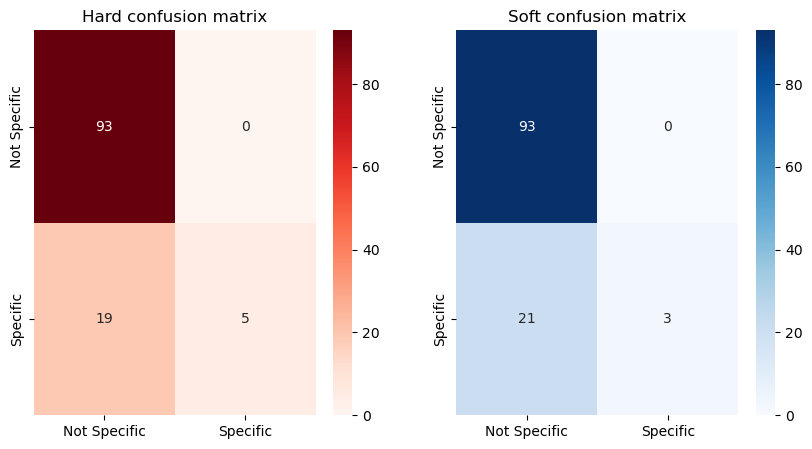


Measurable
Hard 0.811965811965812
Soft 0.8205128205128205


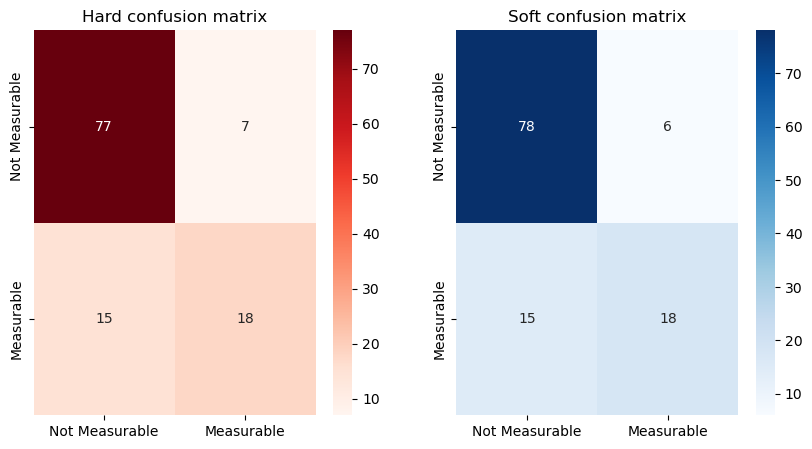


Action-oriented
Hard 0.7521367521367521
Soft 0.7606837606837606


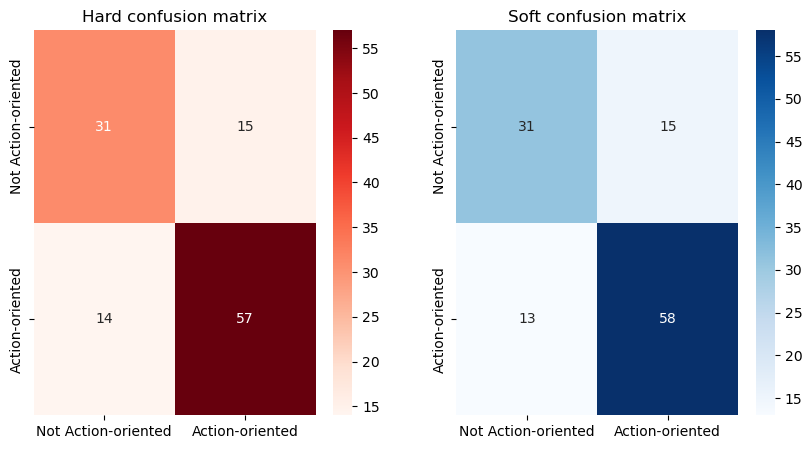


Time-bound
Hard 0.9572649572649573
Soft 0.9572649572649573


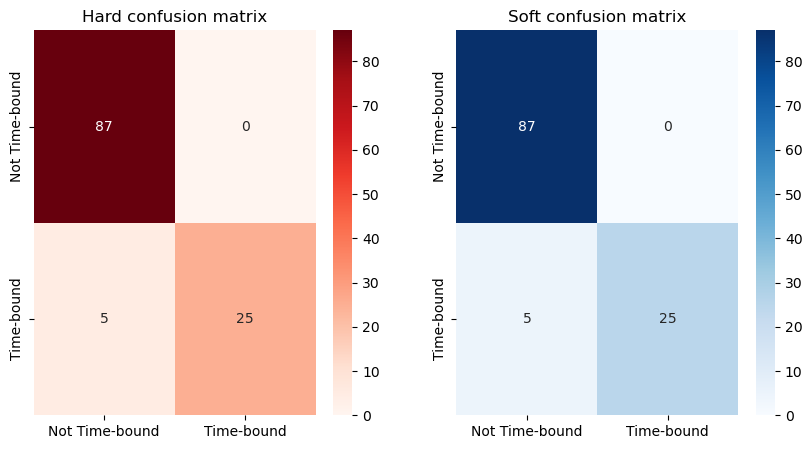

In [12]:
# Create a list of models to include in the ensemble
from sklearn.ensemble import VotingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


X = data['Goal']
classes = ['Specific', 'Measurable', 'Action-oriented',  'Time-bound']

ensembles = {}

for c in classes:
    print(c)
    
    # Split the data into training and testing sets
    X_train_vec, X_test_vec, y_train, y_test = prep_data_for_classifying(data, 'Goal', c)

    # Create a list of models to include in the ensemble
    models = [('lr', best_lr_models[c]), ('svc', best_svc_models[c]), ('rf', best_rf_models[c])]

    # Create an ensemble model
    ensemble_hard = VotingClassifier(estimators=models, voting='hard')
    ensemble_hard.fit(X_train_vec, y_train)
    print("Hard", ensemble_hard.score(X_test_vec, y_test))

    ensemble_soft = VotingClassifier(estimators=models, voting='soft')
    ensemble_soft.fit(X_train_vec, y_train)
    print("Soft", ensemble_soft.score(X_test_vec, y_test))

    # visualize confusion matrix
    y_pred = ensemble_hard.predict(X_test_vec)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not ' + c, c], yticklabels=['Not ' + c, c], cmap ='Reds', ax=ax1)
    ax1.set_title('Hard confusion matrix')


    y_pred_2 = ensemble_soft.predict(X_test_vec)
    cm_2 = confusion_matrix(y_test, y_pred_2)
    sns.heatmap(cm_2, annot=True, fmt='d', xticklabels=['Not ' + c, c], yticklabels=['Not ' + c, c], cmap='Blues', ax=ax2)
    ax2.set_title('Soft confusion matrix')

    plt.show()

    # get the ensemble with the best score and store it in dict, fitted to data
    if ensemble_hard.score(X_test_vec, y_test) > ensemble_soft.score(X_test_vec, y_test):
        ensembles[c] = ensemble_hard
    else:
        ensembles[c] = ensemble_soft

    print()

Overall, the ensemble model has a very high accuracy for both the soft and the hard classifiers, even with the highly varied data. However, looking at the confusion matrices, it can be bound to false negatives, which likely stems from not sufficient high-quality SMART goals. If possible, the next steps would be augmenting the data by modifying or correcting the new year's resolutions.

# Next steps using Transformers

## Helper functions

In [13]:
def sample_goal(data):
  # randomly sample goal
  goal = data['Goal'].sample(1).values[0]
  return goal


def fit_vectorizer(data):
  # fit vectorizer to the trained data
  count_vectorizer = CountVectorizer()
  X_train, X_test, y_train, y_test = train_test_split(data['Goal'], data['Specific'], test_size=0.2, random_state=42)
  count_vectorizer.fit_transform(X_train)
  return count_vectorizer


def predict_goal_SMATness(goal, ensembles, classes, count_vectorizer):
  # use previous model to predict how SMAT the goal is
  smatness_dict = {}
  for c in classes:
      pred = ensembles[c].predict(count_vectorizer.transform([goal]))
      smatness_dict[c] = pred
  return smatness_dict


def get_improvements(smatness_dict):
  # use rule-based logic to suggest improvements
  improvements = []
  for k, v in smatness_dict.items():
      if int(v) == 1:
          string = f'This goal is {k.lower()}!'
      else:
          string = f'This goal is not {k.lower()}. Maybe you should'
          improvements.append(string)
  return improvements


def goal_feedback_pipeline(data, ensembles, classes):
  # pipeline for the above
  goal = sample_goal(data)
  count_vectorizer = fit_vectorizer(data)

  smatness = predict_goal_SMATness(goal, ensembles, classes, count_vectorizer)

  improvements = get_improvements(smatness)

  return goal, smatness, improvements


goal, smatness, improvements = goal_feedback_pipeline(data, ensembles, classes)
print(goal)
print(improvements)



Attend the Temple A LOT
['This goal is not specific. Maybe you should', 'This goal is not measurable. Maybe you should', 'This goal is not time-bound. Maybe you should']


## Feedback from transformers

### Explanation

GPT-2 (Generative Pre-trained Transformer 2) is a transformer-based neural network architecture that serves as an unsupervised language model that uses self-attention mechanisms to model the probability distribution of natural language.

The architecture of GPT-2 consists of a stack of transformer decoders, where each decoder has multiple layers. The input to the network is a sequence of tokens, which are first embedded into a high-dimensional vector space. The embedding is then fed into the first transformer decoder layer, which applies multi-head self-attention mechanism, followed by a feedforward network, and then a layer normalization operation. The output of the first decoder layer is then fed into the second decoder layer, and so on, until the final decoder layer.

The multi-head self-attention mechanism is what allows the model to capture dependencies between different positions in the input sequence by attending to all positions in the sequence simultaneously, instead of just the previous positions. This enables the model to learn contextual relationships between words, which is particularly important in natural language processing tasks.

GPT-2 was trained on a massive amount of text data, using a unsupervised learning approach called language modeling. During training, the model was presented with a sequence of words and was trained to predict the next word in the sequence. This process of predicting the next word is known as autoregression. The model was trained to minimize the negative log-likelihood of the correct next word, given the previous context. 

Pseudocode for GPT-2:

1. Input: a sequence of tokens x_1, x_2, ..., x_n.
2. Embed the sequence of tokens into a high-dimensional vector space using an embedding layer.
3. Feed the embedded sequence into the first transformer decoder layer: <br>
  a. Apply multi-head self-attention mechanism to capture dependencies between all positions in the sequence.
  b. Apply a feedforward network to the output of the self-attention mechanism.
  c. Apply layer normalization to the output of the feedforward network.
4. Feed the output of the first decoder layer into the second decoder layer, and repeat step 3.
5. Repeat step 4 until the final decoder layer is reached.
6. Output: a probability distribution over the possible next token, given the input sequence. This can be used for tasks such as text generation, question answering, or language translation.


Then, to generate text.

Inputs: A probability distribution (logits), a parameter that controls the "creativity" of the generated text (temperature), a parameter to pick the words with the highest probability for a token (top_k), a parameter to pick the words that allows the highest coverage of the tokens' meaning (top_p).
1. Convert the probability distribution into the probabilities of the next token by applying softmax to the logits, and divide by the temperature.
2. Sample the index of the next token according to the probability distribution obtained in (1).
3. Convert the index of the next token to its corresponding text representation using the GPT-2 tokenizer.
4. If the generated token is an end-of-sequence token (e.g., a period), stop generating text.
5. Append the generated token to generated_text.
6. Return the genereated text.

In [14]:
goal, smatness, improvements = goal_feedback_pipeline(data, ensembles, classes)
print(goal)

for improv in improvements:
  input_ids = tokenizer.encode(improv, return_tensors='tf')

  model_output = model.generate(
      input_ids,  
      max_length=50, 
      top_k = 50,
      top_p = 0.95
  )

  print("Output:\n" + 30 * '-')
  print(tokenizer.decode(model_output[0], skip_special_tokens=True))

Get Rich or Cry Trying
Output:
------------------------------
This goal is not specific. Maybe you should try to do it in a different way.

The goal is to make sure that you are using the right tools.

The goal is to make sure that you are using the right tools.
Output:
------------------------------
This goal is not measurable. Maybe you should try to get a better idea of what you're doing.

If you're not sure what you're doing, try to figure out what you're doing.

If you're not sure what
Output:
------------------------------
This goal is not action-oriented. Maybe you should be able to do something like this:

$ cat /proc/sys/kernel/kernel.c

This will create a file /proc/sys/kernel/kernel.c
Output:
------------------------------
This goal is not time-bound. Maybe you should try it out.

The goal is to get your team to play well.

The goal is to get your team to play well.

The goal is to get your team


### Adding more context

Adding more context can improve GPT-2 performance because there is more information on which to base the next word (i.e., the options are narrowed down).

To explain this, in the attention mechanism of GPT-2, each token in the input sequence is associated with a key, a value, and a query vector, represented as matrices K, V, and Q respectively. The attention weight matrix A is then calculated as:

$$A = softmax(QK^T / \sqrt{d_k})$$

where $d_k$ is the dimensionality of the key vectors.

With more data, the model has more examples to learn from, which means that it can learn more robust representations of the key (K), value (V), and query (Q) vectors. Mathematically, this means that the model can adjust the parameters of its neural network to better map the input data to these vectors. Specifically, the model can learn to associate the relevant keys with their corresponding values and queries, which allows it to more accurately attend to the most relevant tokens in the input sequence. This ultimately results in better contextual representation of the input sequence and improved performance in downstream tasks.

In [15]:

def get_improvements_with_reasons(smatness_dict):
  reasons_goal_bad = {
    'Specific' : 'it is too broad or vague.',
    'Measurable' : 'there is no clear way to track progress or measure success. ',
    'Action-oriented' : 'it is not tied to a specific action or behavior. ',
    'Time-bound' : 'there is no specific deadline or timeline for achieving it.'
  }

  improvements = []
  for k, v in smatness_dict.items():
      if int(v) == 1:
          string = f'This goal is {k.lower()}!'
      else:
          string = f'This goal is not {k.lower()}.'
          string += f'\n This could be because {reasons_goal_bad[k]}'
          string += f'\n Maybe you should'
          improvements.append(string)
  return improvements


def adj_goal_feedback_pipeline(data, ensembles, classes):
  # pipeline for the above
  goal = sample_goal(data)
  count_vectorizer = fit_vectorizer(data)

  smatness = predict_goal_SMATness(goal, ensembles, classes, count_vectorizer)

  improvements = get_improvements_with_reasons(smatness)

  return goal, smatness, improvements

In [16]:
goal, smatness, improvements = adj_goal_feedback_pipeline(data, ensembles, classes)
print(goal)

for improv in improvements:
  input_ids = tokenizer.encode(improv, return_tensors='tf')

  # activate beam search and early_stopping
  beam_output = model.generate(
      input_ids,  
      max_length=50, 
      early_stopping=True,
      do_sample=True,
      top_k = 50,
      top_p = 0.95
  )

  print("Output:\n" + 30 * '-')
  print(tokenizer.decode(beam_output[0], skip_special_tokens=True))
  print('***')

New Years Resolution I will not take more than one selfie a day NewYearNewMe
Output:
------------------------------
This goal is not specific.
 This could be because it is too broad or vague.
 Maybe you should define a few keywords to allow for more flexible keyword identification.

For example, you want to define the following:

// [
***
Output:
------------------------------
This goal is not measurable.
 This could be because there is no clear way to track progress or measure success. 
 Maybe you should just go through the whole page! But I know this approach has not worked. There is always one metric which
***
Output:
------------------------------
This goal is not time-bound.
 This could be because there is no specific deadline or timeline for achieving it.
 Maybe you should stop waiting and try something else:

Make yourself a more frequent user

Add more features


***


## Results

As can be seen from the example of adding context above, the model has gotten better at generating the output that is relevant to the user. Overall, the aggregation of the classification, rules, and more free-form GPT-2 with extra context has been a success.

### AI Tools

Used ChatGPT for generating text and clarifying understanding of some topics.

### References

https://colab.research.google.com/github/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb 

https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://jalammar.github.io/illustrated-gpt2/ 

